## Imports

In [39]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


# Get data and data split

In [40]:
data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
x_train

,age,gender,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,diploma,group_study,self_study,online_videos,coaching,mixed
3207,20,1,6.48,82.6,0,8.4,0,0,2,0,0,0,0,0,1
1590,18,0,0.68,95.5,1,4.7,2,2,1,0,0,0,1,0,0
593,20,0,0.97,81.5,0,7.9,2,0,1,0,0,0,1,0,0
4707,20,1,7.70,70.4,1,9.7,2,0,2,0,1,0,0,0,0
8571,20,0,1.98,60.4,0,5.8,2,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,24,1,2.24,42.4,1,4.4,1,1,2,0,0,0,0,0,1
3264,24,0,0.86,95.8,1,5.8,0,0,0,0,0,0,1,0,0
9845,22,0,6.32,95.6,1,9.5,0,1,0,0,0,0,0,1,0
10799,22,1,7.71,84.1,1,7.9,2,1,2,0,0,1,0,0,0


# Metric and Optim Functions

## Metric Function

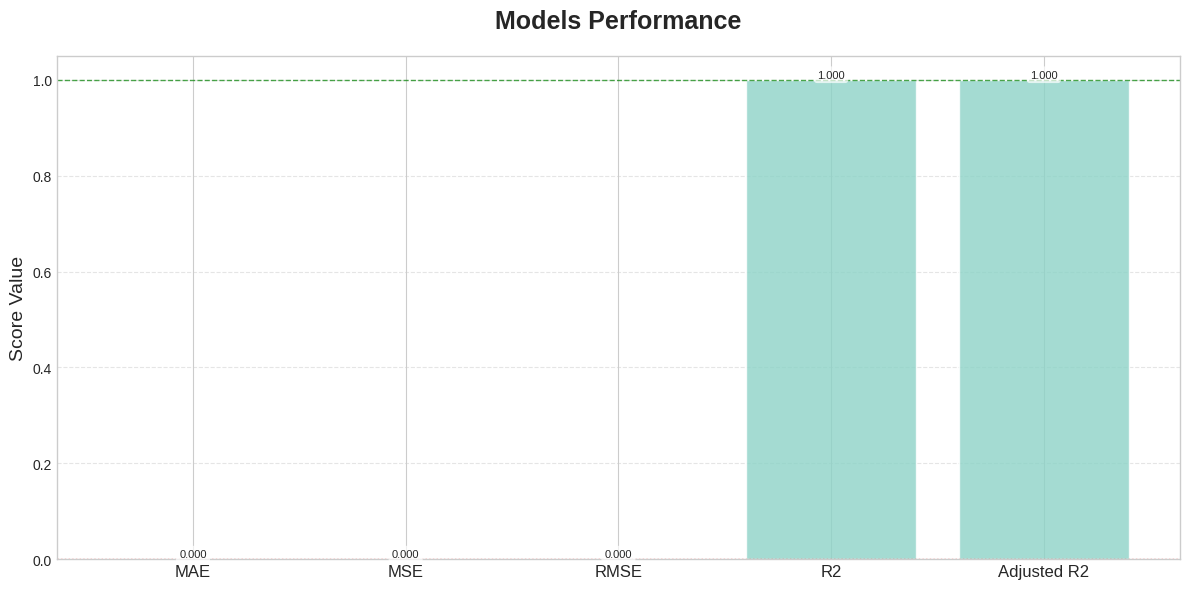

,Metric,Value
0,MAE,0.0
1,MSE,0.0
2,RMSE,0.0
3,R2,1.0
4,Adjusted R2,1.0


In [41]:
def metric(y_hat, y_true,features_shape):
    n,p = features_shape
    r2 = r2_score(y_true, y_hat)
    socres = {
        "MAE": mean_absolute_error(y_true, y_hat),
        "MSE": mean_squared_error(y_true, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "R2": r2,
        "Adjusted R2":  1 - (1 - r2) * (n - 1) / (n - p - 1)
    }

    df_score = pd.DataFrame(socres.items(), columns=["Metric","Value"])

    return df_score


dummy  = metric(y_train, y_train, x_train.shape)

def plot_meterics(df_dict):

    if isinstance(df_dict, pd.DataFrame):
        df_dict = {'Model': df_dict}

    # Define the order and subset of metrics to plot
    metrics_to_plot = ["MAE", "MSE", "RMSE", "R2", "Adjusted R2"]
    metrics_order = {m: i for i, m in enumerate(metrics_to_plot)}

    # Combine and filter dataframes
    all_data = []
    for model_name, df in df_dict.items():
        # Filter for the required metrics
        filtered_df = df[df['Metric'].isin(metrics_to_plot)].copy()
        filtered_df['Model'] = model_name
        all_data.append(filtered_df)

    if not all_data:
        print("Error: No data available to plot after filtering.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)

    # Sort the dataframe according to the predefined metric order
    combined_df['Order'] = combined_df['Metric'].map(metrics_order)
    combined_df.sort_values(by=['Order', 'Model'], inplace=True)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    models = combined_df['Model'].unique()
    n_models = len(models)
    n_metrics = len(metrics_to_plot)
    bar_width = 0.8 / n_models

    x_base = np.arange(n_metrics)

    for i, model in enumerate(models):
        model_data = combined_df[combined_df['Model'] == model]
        values = model_data['Value'].values

        # Calculate position for this model's bars
        offset = (i - (n_models - 1) / 2) * bar_width
        bars = ax.bar(x_base + offset, values, bar_width, label=model, alpha=0.8)

        # Add value labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))


    # Customizing the plot
    ax.set_xticks(x_base)
    ax.set_xticklabels(metrics_to_plot, fontsize=12, fontweight='medium')
    ax.set_ylabel('Score Value', fontsize=14)
    ax.set_title("Models Performance", fontsize=18, fontweight='bold', pad=20)

    # Add legend if needed
    if n_models > 1 or models[0] != 'Model':
        ax.legend(title='Model', fontsize=10, title_fontsize=12, frameon=True, shadow=True)

    # Add horizontal lines for R2/Adj R2 targets for context
    ax.axhline(1.0, color='green', linestyle='--', linewidth=1.0, alpha=0.7, label='Perfect Fit (R2=1.0)')
    ax.axhline(0.0, color='red', linestyle=':', linewidth=1.0, alpha=0.7, label='Baseline Fit (R2=0.0)')

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

results_dict = {}

plot_meterics(dummy)
dummy

## Train and optim function
We change models and optimize for model parameters and KBest Feature Selector

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import optuna

names = x_train.columns
optuna.logging.set_verbosity(optuna.logging.WARNING)


def selected_features(selector):
    global names

    mask = selector.get_support()
    selected_names = np.array(names)[mask]
    return list(selected_names)

def optimize_train_and_judge(title, model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()

    pipe = Pipeline([('scaler', StandardScaler()),('features_selector', SelectKBest(score_func=f_regression)) ,('regressor', model_class())])
    pipe.set_params(**study.best_params)
    pipe.fit(x_train, y_train)


    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")

    # Metrics
    preds = pipe.predict(x_test)
    results = metric(preds, y_test, [x_test.shape[0],len(names_selected)])

    return pipe, results

# Pipelines

## Linear Regression

In [43]:
from sklearn.linear_model import LinearRegression


def objective_linear(trial):
    num_features = x_train.shape[1]
    k = trial.suggest_int('features_selector__k', 1, num_features)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('features_selector', SelectKBest(score_func=f_regression, k=k)),
        ('regressor', LinearRegression())
    ])


    score = cross_val_score(pipe,x_train,
        y_train,
        n_jobs=-1,
        cv=5,
        scoring='neg_mean_squared_error'
    ).mean()

    return score

LinearPipe, results_dict['LinearRegression'] = optimize_train_and_judge('LinearRegression', LinearRegression, objective_linear, trails=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Selected features: ['study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality', 'facility_rating', 'group_study', 'self_study', 'online_videos', 'coaching']
Optimize time: 0.9413394927978516


### Results

In [44]:
results_dict['LinearRegression']

,Metric,Value
0,MAE,8.002713
1,MSE,99.089533
2,RMSE,9.954373
3,R2,0.722967
4,Adjusted R2,0.722339


# Tree

In [46]:
from sklearn.tree import DecisionTreeRegressor

def objective_dt(trial):
    global x_train, y_train

    k = trial.suggest_int('features_selector__k', 1, x_train.shape[1])

    params = {
        'regressor__ccp_alpha': trial.suggest_float('regressor__ccp_alpha', 0.0, 0.05),
        'regressor__criterion': trial.suggest_categorical('regressor__criterion',
                                                         ['squared_error', 'friedman_mse', 'absolute_error']),
        'regressor__min_samples_split': trial.suggest_int('regressor__min_samples_split', 2, 20)
    }

    # 3. Define the Pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('features_selector', SelectKBest(score_func=f_regression, k=k)),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])
    pipe.set_params(**params)

    score = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    ).mean()

    return score

ForestPipe, results_dict['PrunedTree'] = optimize_train_and_judge('PrunedTree', LinearRegression, objective_linear, trails=20)
results_dict['PrunedTree']

  0%|          | 0/20 [00:00<?, ?it/s]

Selected features: ['study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality', 'facility_rating', 'group_study', 'self_study', 'online_videos', 'coaching']
Optimize time: 1.0415632724761963


,Metric,Value
0,MAE,8.002713
1,MSE,99.089533
2,RMSE,9.954373
3,R2,0.722967
4,Adjusted R2,0.722339


# RandomForestRegressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

def objective_rf(trial):
    k = trial.suggest_int('features_selector__k', 1, x_train.shape[1])

    params = {
        'regressor__n_estimators': trial.suggest_int('regressor__n_estimators', 10, 200),
        'regressor__max_depth': trial.suggest_int('regressor__max_depth', 2, 32),
    }

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('features_selector', SelectKBest(score_func=f_regression, k=k)),
        ('regressor', RandomForestRegressor())
    ])

    pipe.set_params(**params)

    score = cross_val_score(pipe, x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

ForestPipe, results_dict['RandomForestRegressor'] = optimize_train_and_judge('RandomForestRegressor', LinearRegression, objective_linear, trails=20)
results_dict['RandomForestRegressor']

  0%|          | 0/20 [00:00<?, ?it/s]

Selected features: ['study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality', 'facility_rating', 'group_study', 'self_study', 'online_videos', 'coaching']
Optimize time: 1.0545384883880615


,Metric,Value
0,MAE,8.002713
1,MSE,99.089533
2,RMSE,9.954373
3,R2,0.722967
4,Adjusted R2,0.722339
